# ENGR-E 533: Deep Learning Systems
## Homework 1

### Khandokar Md. Nayem (knayem@iu.edu)
### Mar 7, 2018

### Import necessary files and set environment parameters
My assigned Node is `r-006` and GPU `1`.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import numpy as np
from operator import itemgetter
import time
import heapq
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Importing MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
NUM_ITERATION = 1000 # Number of iteration number in Train
TRAIN_BATCH_SIZE = 1000 # Sample 1000 Train batch
TEST_BATCH_SIZE = 1000 # Sample 1000 Test batch

### Xavier Initialization of Weights
These are the weight initialization function used in defining model.

In [4]:
def weight_variable (shape):
    initial = tf.truncated_normal(shape, stddev = np.sqrt(2.0/sum(shape)) )
    return tf.Variable(initial)

def bias_variable (shape):
    initial = tf.truncated_normal(shape, stddev = np.sqrt(1.0/sum(shape)) )
    return tf.Variable(initial)

### Create the fully connected model 

In [5]:
x = tf.placeholder(tf.float32, [None, 784]) 

W_1 = weight_variable([784, 1024])
b_1 = bias_variable([1024])

W_2 = weight_variable([1024, 1024])
b_2 = bias_variable([1024])

W_3 = weight_variable([1024, 1024])
b_3 = bias_variable([1024])

W_4 = weight_variable([1024, 1024])
b_4 = bias_variable([1024])

W_5 = weight_variable([1024, 10])
b_5 = bias_variable([10])




# Layer connections and Activation functions
y_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)
y_2 = tf.nn.relu(tf.matmul(y_1, W_2) + b_2)
y_3 = tf.nn.relu(tf.matmul(y_2, W_3) + b_3)
y_4 = tf.nn.relu(tf.matmul(y_3, W_4) + b_4)
y = tf.matmul(y_4, W_5) + b_5 # predicted

y_ = tf.placeholder(tf.float32, [None, 10]) # original

# Define loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

### Run the model (Q1, Q2)
On average, `Accuracy` on test batch is over `98%`. If we increase the number of iteration (Line 10, currently 1000), `Accuracy` increases; but more time is needed to train.

In [6]:
# Configuration to control GPU use
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33
sess = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()


# Train Model
for _ in range(NUM_ITERATION):
    batch_xs, batch_ys = mnist.train.next_batch(TRAIN_BATCH_SIZE)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy:",sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels}))

Accuracy: 0.9788


### Last (5th) Layer vizualization (Q3)

<IPython.core.display.Javascript object>


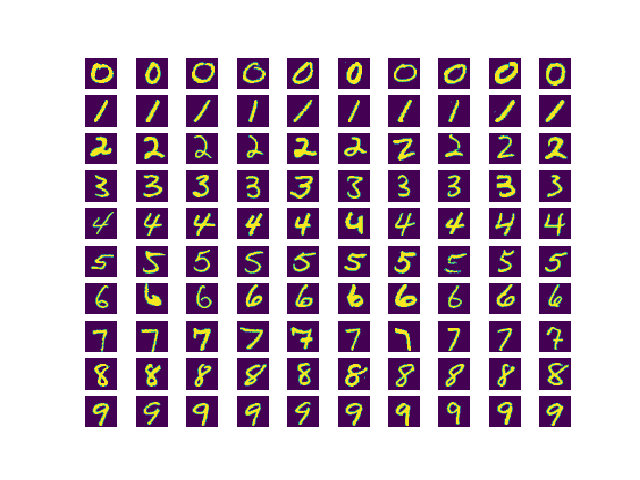

In [7]:
y_est = tf.nn.softmax(y)

batch_xs, batch_ys = mnist.test.next_batch(TEST_BATCH_SIZE)
# y_np -> last layer output
# y_np4 -> 4th layer output
y_np,y_np4=sess.run([y_est,y_4], feed_dict={x: batch_xs})
# y_np,y_np4=sess.run([y_est,y_4], feed_dict={x: mnist.test.images[:TEST_BATCH_SIZE,]})


# For 10 images for 10 classes
class_dict = dict()
for c in range(10):
    class_dict[c]=[]

# For image predicted class (image_index, probability)
for r in range(y_np.shape[0]):
    key = np.argmax(y_np[r])
    class_dict[key].append( (r, np.amax(y_np[r]) ) )
    
# Get top 10 images with largest probability
for t in range(10):
    class_dict[t].sort(key=itemgetter(1),reverse=True)
    if len(class_dict[t]) > 10:
        class_dict[t] = class_dict[t][0:10]
        
    # For each class, (image_index, probability)
    # print(x, class_dict[x])

    
# 10-by-10 image grid
%matplotlib notebook
plt.figure()

c=0
for key in range(10):
    i=0
    for elem in class_dict[key]:
        plt.subplot(10,10,(c*10+i)+1)
#         plt.imshow( mnist.test.images[int(elem[0])].reshape((28,28)) )
        plt.imshow( batch_xs[int(elem[0])].reshape((28,28)) )
        plt.axis('off')
        plt.show()
        i +=1
    c+=1

### Second to Last (4th) Layer vizualization (Q4)

**Q4-Answer**: 
We can see that not all 10 selected neurons have 10 images and a neuron's output are from different classes, whereas in the plot of `1.3` all the neurons are showing 10 images and a neuron's output are from same classes. That's because in `1.3`, the output layer neurons are trained to learn the pattern of MNIST Digit Images, and each output neuron represents a single class. So in ideal situation all the images of a row shows same digit. Since accuracy of our model is pretty decent, we get 10 same digits in a neuron (ideal senerio) when testing for 1000 images.

But the situation is a bit different for $4^{th}$ layer (second to last layer). There are 1024 neurons in that layer and they are trying to learn the model. For a test image depending on its class, different neurons activated (give highest probability). Since we randomly selected 10 neurons and consider them as complete output, it is quite common that a selected neuron doesn't learn any class or other neurons learn better than the selected neuron. If selected neuron doesn't learn any class or other selected neurons learn images better than it, there is no images for that neuron. And if there is other neuron learn a class better that the selected neuron but that neuron is not in the selected neuron list, then images from different class can activate same neuron.

In ideal situation, all the images of a neuron should be same but number of images can still vary.

Selected Neuron: [614 549 841 334 918 557 601 233 485 988]


<IPython.core.display.Javascript object>


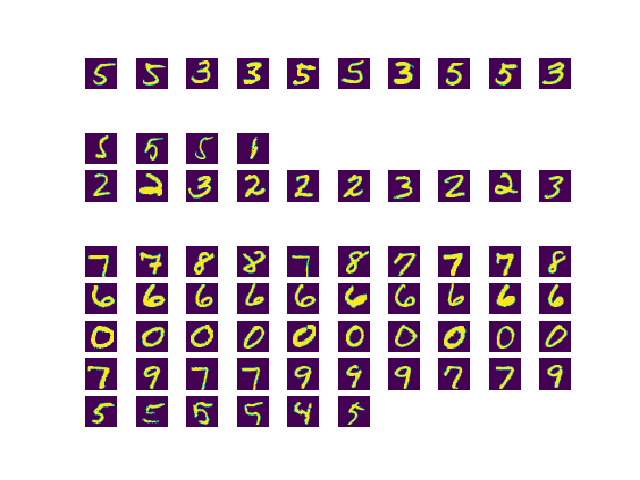

In [8]:
# y_np4 =sess.run(y_4, feed_dict={x: mnist.test.images[:TEST_BATCH_SIZE,]})

# Choose 10 random neurons from 1024 neurons of 4th layer
random_neuron = np.random.choice(1024, size=10, replace=False)
print('Selected Neuron:', random_neuron)

# For 10 images for 10 classes
class_dict = dict()
for c in range(10):
    class_dict[c]=[]
    
# For image predicted class (image_index, probability)
for r in range(y_np4.shape[0]):
    key = np.argmax(y_np4[r][random_neuron])
    class_dict[key].append( (r, np.amax(y_np4[r][random_neuron]) ) )
    
for t in range(10):
    class_dict[t].sort(key=itemgetter(1),reverse=True)
    if len(class_dict[t]) > 10:
        class_dict[t] = class_dict[t][0:10]
        
    # For each class, (image_index, probability)
    # print(x, class_dict[x])


# 10-by-10 image grid
%matplotlib notebook
plt.figure()

c=0
for key in range(10):
    i=0
    for elem in class_dict[key]:
        plt.subplot(10,10,(c*10+i)+1)
#         plt.imshow( mnist.test.images[int(elem[0])].reshape((28,28)) )
        plt.imshow( batch_xs[int(elem[0])].reshape((28,28)) )
        plt.axis('off')
        plt.show()
        i +=1
    c+=1

### Apply (tSNE+PCA) to plot in 2D (Q5, Q6)
**Q6-Answer**: 
We apply use PCA and tSNE to reduce the dimention of the images in 2-dim. If we inspect the mean of the 10 classes, they are kind of meshed up close by. Since images of the same classes are here and there in the plot, we can deduct that this raw image samples are not easy to classify. 

In [9]:
# Get a new train batch
batch_xs, batch_ys = mnist.train.next_batch(TRAIN_BATCH_SIZE)
batch_ys = np.argmax(batch_ys, axis=1)

# First using PCA, we minimize the dimention to 50
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(batch_xs)

# Then using tSNE, we minimize the dimention to 2
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.748352
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.180450
[t-SNE] Error after 300 iterations: 1.218239


In [10]:
# Separate 2D point array for each class
points_0,points_1,points_2,points_3,points_4 = None, None,None, None,None
points_5,points_6,points_7,points_8,points_9 = None, None,None, None,None

for i,b in enumerate(batch_ys):
    if b ==0:
        points_0 = np.array( [ tsne_pca_results[i,:] ] ) if points_0 is None else np.concatenate( (points_0, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 1:
        points_1 = np.array( [ tsne_pca_results[i,:] ] ) if points_1 is None else np.concatenate( (points_1, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 2:
        points_2 = np.array( [ tsne_pca_results[i,:] ] ) if points_2 is None else np.concatenate( (points_2, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 3:
        points_3 = np.array( [ tsne_pca_results[i,:] ] ) if points_3 is None else np.concatenate( (points_3, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 4:
        points_4 = np.array( [ tsne_pca_results[i,:] ] ) if points_4 is None else np.concatenate( (points_4, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 5:
        points_5 = np.array( [ tsne_pca_results[i,:] ] ) if points_5 is None else np.concatenate( (points_5, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 6:
        points_6 = np.array( [ tsne_pca_results[i,:] ] ) if points_6 is None else np.concatenate( (points_6, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 7:
        points_7 = np.array( [ tsne_pca_results[i,:] ] ) if points_7 is None else np.concatenate( (points_7, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 8:
        points_8 = np.array( [ tsne_pca_results[i,:] ] ) if points_8 is None else np.concatenate( (points_8, [tsne_pca_results[i,:]]),axis=0 )
    elif b == 9:
        points_9 = np.array( [ tsne_pca_results[i,:] ] ) if points_9 is None else np.concatenate( (points_9, [tsne_pca_results[i,:]]),axis=0 )

        
# mean for each 10 classes        
mean = np.array( [np.mean(points_0, axis=0)] )
mean = np.concatenate( (mean,np.array([np.mean(points_1, axis=0)]),np.array([np.mean(points_2, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_3, axis=0)]),np.array([np.mean(points_4, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_5, axis=0)]),np.array([np.mean(points_6, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_7, axis=0)]),np.array([np.mean(points_8, axis=0)]) ) ,axis=0)
mean = np.concatenate( (mean,np.array([np.mean(points_9, axis=0)]) ) ,axis=0)
print("Means:\n",mean)

Means:
 [[  9.629307    -5.629694  ]
 [ -5.711479     1.4516956 ]
 [ -4.9331555    3.1782455 ]
 [ -3.1494446   12.691868  ]
 [ -1.8538903  -10.93696   ]
 [  0.90450156   7.615301  ]
 [ 10.516477     2.3682272 ]
 [ -1.1387082   -5.3817635 ]
 [ -2.082841     6.478478  ]
 [ -1.4040445   -9.85943   ]]


<IPython.core.display.Javascript object>


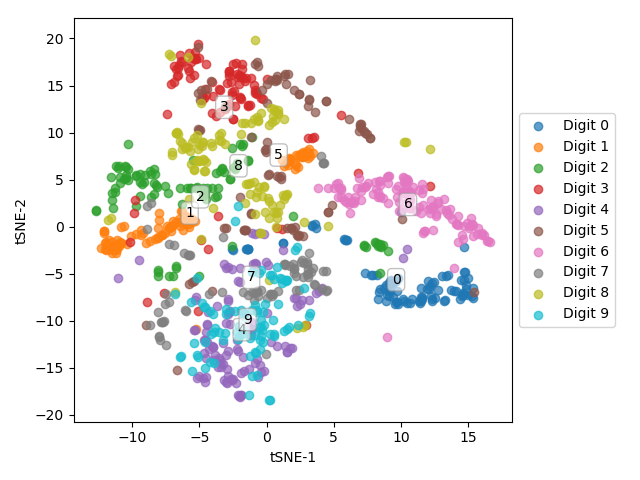

In [21]:
# Color code for 10 class
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

%matplotlib notebook
plt.figure()
bbox_props = dict(boxstyle="round", fc="w", ec="0.6", alpha=0.6)


plt.scatter(points_0[:,0], points_0[:,1], c=colors[0] , alpha=0.7, label='Digit 0')
# plt.scatter(mean[0,0],mean[0,1], c=colors[0], alpha=1,marker='X', label='mean 0')
plt.text(mean[0,0],mean[0,1], "0", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 0', xy=( mean[0,0],mean[0,1] ), xytext=(0, -15),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_1[:,0], points_1[:,1], c = colors[1] , alpha=0.7, label='Digit 1')
# plt.scatter(mean[1,0],mean[1,1], c=colors[1], alpha=1,marker='X', label='mean 1')
plt.text(mean[1,0],mean[1,1], "1", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 1', xy=( mean[1,0],mean[1,1] ), xytext=(6, 7),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_2[:,0], points_2[:,1], c = colors[2] , alpha=0.7, label='Digit 2')
# plt.scatter(mean[2,0],mean[2,1], c=colors[2], alpha=1,marker='X', label='mean 2')
plt.text(mean[2,0],mean[2,1], "2", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 2', xy=( mean[2,0],mean[2,1] ), xytext=(10, 10),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_3[:,0], points_3[:,1], c = colors[3] , alpha=0.7, label='Digit 3')
# plt.scatter(mean[3,0],mean[3,1], c=colors[3], alpha=1,marker='X', label='mean 3')
plt.text(mean[3,0],mean[3,1], "3", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 3', xy=( mean[3,0],mean[3,1] ), xytext=(10, -15),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_4[:,0], points_4[:,1], c = colors[4] , alpha=0.7, label='Digit 4')
# plt.scatter(mean[4,0],mean[4,1], c=colors[4], alpha=1,marker='X', label='mean 4')
plt.text(mean[4,0],mean[4,1], "4", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 4', xy=( mean[4,0],mean[4,1] ), xytext=(0, 2),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_5[:,0], points_5[:,1], c = colors[5] , alpha=0.7, label='Digit 5')
# plt.scatter(mean[5,0],mean[5,1], c=colors[5], alpha=1,marker='X', label='mean 5')
plt.text(mean[5,0],mean[5,1], "5", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 5', xy=( mean[5,0],mean[5,1] ), xytext=(-15, -10),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_6[:,0], points_6[:,1], c = colors[6] , alpha=0.7, label='Digit 6')
# plt.scatter(mean[6,0],mean[6,1], c=colors[6], alpha=1,marker='X', label='mean 6')
plt.text(mean[6,0],mean[6,1], "6", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 6', xy=( mean[6,0],mean[6,1] ), xytext=(-5, 17),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_7[:,0], points_7[:,1], c = colors[7] , alpha=0.7, label='Digit 7')
# plt.scatter(mean[7,0],mean[7,1], c=colors[7], alpha=1,marker='X', label='mean 7')
plt.text(mean[7,0],mean[7,1], "7", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 7', xy=( mean[7,0],mean[7,1] ), xytext=(-13, 5),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_8[:,0], points_8[:,1], c = colors[8] , alpha=0.7, label='Digit 8')
# plt.scatter(mean[8,0],mean[8,1], c=colors[8], alpha=1,marker='X', label='mean 8')
plt.text(mean[8,0],mean[8,1], "8", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 8', xy=( mean[8,0],mean[8,1] ), xytext=(-5, -10),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.scatter(points_9[:,0], points_9[:,1], c = colors[9] , alpha=0.7, label='Digit 9')
# plt.scatter(mean[9,0],mean[9,1], c=colors[9], alpha=1,marker='X', label='mean 9')
plt.text(mean[9,0],mean[9,1], "9", ha="center", va="center", bbox=bbox_props)
# plt.annotate('mean 9', xy=( mean[9,0],mean[9,1] ), xytext=(5, -5),
#             arrowprops=dict(facecolor='black', shrink=0.005),
#             )

plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.8) 
plt.show()


### tSNE+PCA for all layer (Q7, Q8)
**Q7-Answer:** 
When we transform input data (784-dim) into a 1024-dim space, we hope to creat a sparse model. Since from the observation of _Q6_, we see that it is not easy to classify them from raw images, we expect that a sparse model will make them easy to classify. That is the reason to transform the input in larger dimentional space. 

**Q8-Answer:** 
The plots shows how each layer transform the input into another hyper-space and make them easier to classify correctly. As we go higher dimentional space, the data of same classes are cluster together. 

In [12]:
# Take softmax of output for each layer
y_est_1 = tf.nn.softmax(y_1)
y_est_2 = tf.nn.softmax(y_2)
y_est_3 = tf.nn.softmax(y_3)
y_est_4 = tf.nn.softmax(y_4)
y_est_5 = tf.nn.softmax(y)

# Get a new train batch
batch_xs, batch_ys = mnist.test.next_batch(TEST_BATCH_SIZE)

y_np5,y_np4,y_np3,y_np2,y_np1 =sess.run([y_est_5,y_est_4,y_est_3,y_est_2,y_est_1], 
                                          feed_dict={x: batch_xs})

batch_ys = np.argmax(batch_ys, axis=1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.002305
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.054565
[t-SNE] Error after 300 iterations: 0.830027


<IPython.core.display.Javascript object>


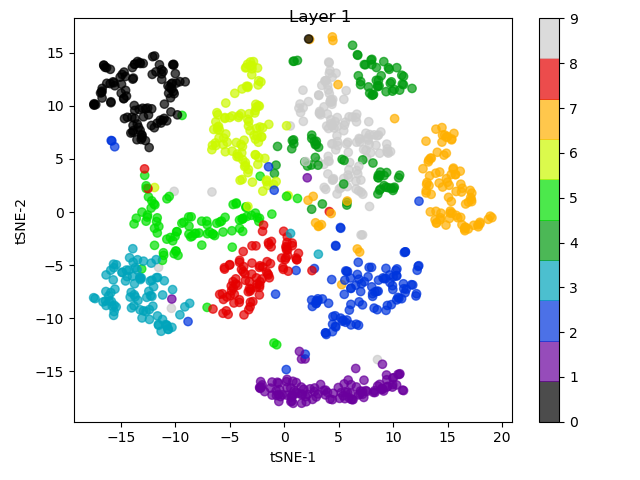

In [13]:
## For 1st Layer
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(y_np1)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)


%matplotlib notebook
plt.figure()

# sb1=plt.subplot(5,1,1)
plt.suptitle("Layer 1")
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.tight_layout()
plt.colorbar()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.002222
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.764668
[t-SNE] Error after 300 iterations: 0.544941


<IPython.core.display.Javascript object>


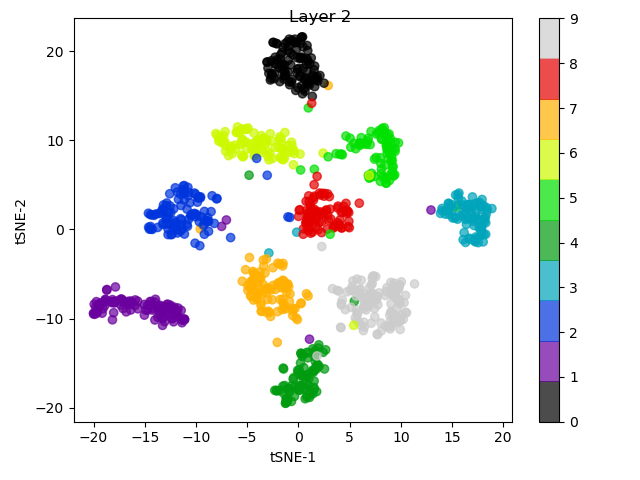

In [14]:
## For 2nd Layer
pca_result_50 = pca_50.fit_transform(y_np2)
tsne_pca_results = tsne.fit_transform(pca_result_50)

%matplotlib notebook
plt.figure()
# sb2=plt.subplot(5,1,2) 
plt.suptitle("Layer 2")
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.tight_layout()
plt.colorbar()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.124s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.003456
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.285675
[t-SNE] Error after 300 iterations: 0.431898


<IPython.core.display.Javascript object>


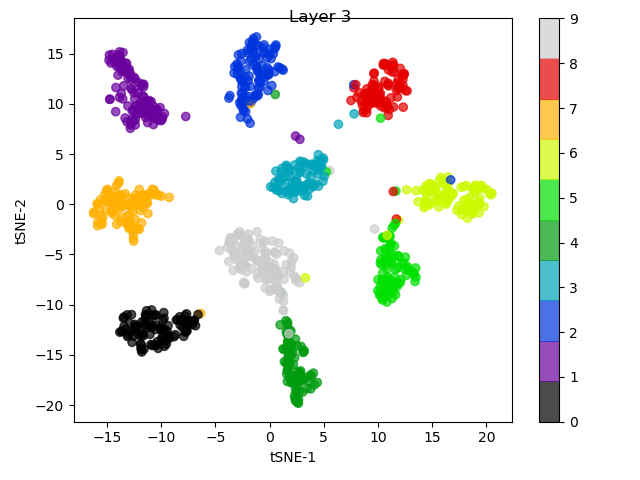

In [15]:
## For 3rd Layer
pca_result_50 = pca_50.fit_transform(y_np3)
tsne_pca_results = tsne.fit_transform(pca_result_50)

%matplotlib notebook
plt.figure()
# sb3=plt.subplot(5,1,3) 
plt.suptitle("Layer 3")
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.tight_layout()
plt.colorbar()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.009228
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.330551
[t-SNE] Error after 300 iterations: 0.370206


<IPython.core.display.Javascript object>


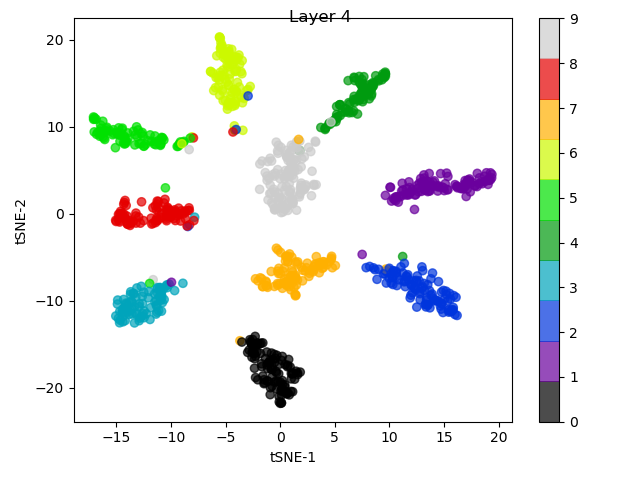

In [16]:
## For 4th Layer
pca_result_50 = pca_50.fit_transform(y_np4)
tsne_pca_results = tsne.fit_transform(pca_result_50)

%matplotlib notebook
plt.figure()
# sb4=plt.subplot(5,1,4)
plt.suptitle("Layer 4")     
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.tight_layout()
plt.colorbar()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.527531
[t-SNE] Error after 300 iterations: 0.272219


<IPython.core.display.Javascript object>


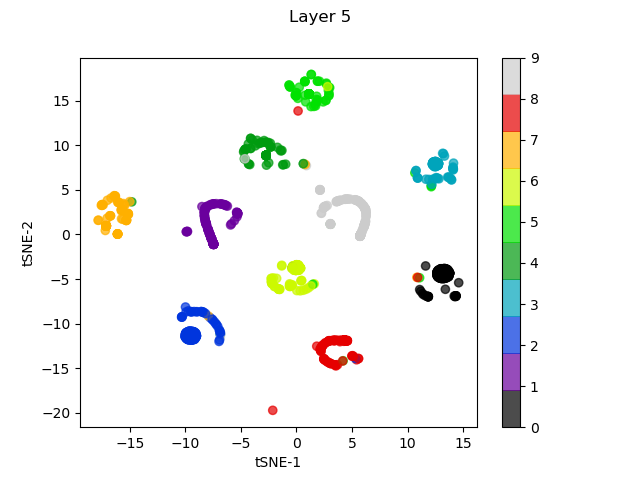

In [17]:
## For 5th Layer
pca_5 = PCA(n_components=5)
pca_result_5 = pca_5.fit_transform(y_np5)
tsne_pca_results = tsne.fit_transform(pca_result_5)

%matplotlib notebook
plt.figure()
# sb5=plt.subplot(5,1,5)
plt.suptitle("Layer 5")
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, alpha=0.7, cmap=plt.cm.get_cmap("nipy_spectral", 10))
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")

plt.colorbar()
plt.show()